In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from optim.functions.player_gain_expected_value import player_gain_expected_value, player_gain_expected_value_numpy
from optim.functions.player_gain_variance import player_gain_variance, player_gain_variance_numpy
from optim.functions.player_utility_kelly_criteria import player_utility_kelly_criteria
from optim.functions.player_utility_linear import player_utility_linear
from optim.functions.player_utility_sharp_ratio import player_utility_sharp_ratio

from optim.resolve.resolve_fik import resolve_fik
from optim.resolve.simulate_prob import simulate_prob

# Paramètres de la simulation
M = 10  # Nombre de matchs
N = 3   # Nombre de résultats possibles par match (ex: victoire, nul, défaite)
T = 40 # Nombre de pas
H = 30 # Nombre de simulations
B = 1 # Bankroll initiale

BIAS_BOOKMAKER = 0.05  # Biais de la distribution des probabilités du bookmaker
BIAS_PLAYER = 0.01      # Biais de la distribution des probabilités du joueur
STD_BOOKMAKER = 0.1  # Ecart-type de la distribution des cotes du bookmaker
STD_PLAYER = 0.05      # Ecart-type de la distribution des cotes du joueur
MARGIN_BOOKMAKER = 0.1  # Marge du bookmaker
MIN_PROB = 0.05  # Probabilité minimale d'un résultat
MAX_PROB = 0.95  # Probabilité maximale d'un résultat

np.set_printoptions(precision=2, suppress=True)

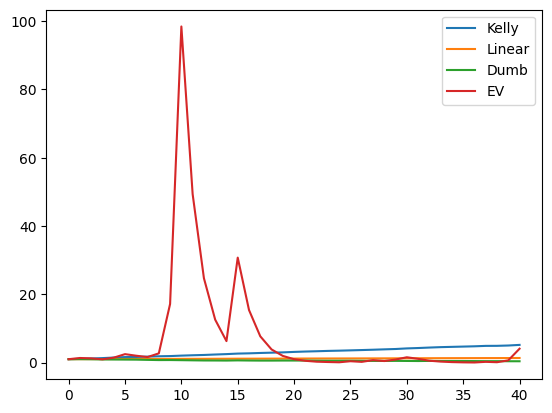

In [134]:
    
result_kelly = []
result_linear = []
result_dumb = []
result_ev = []


for h in range(H):

    B_kelly = B
    B_linar = B
    B_dumb = B
    B_ev = B
    B_list_kelly = [B]
    B_list_linear = [B]
    B_list_dum = [B]
    B_list_ev = [B]

    for t in range(T):
        r, o, t = simulate_prob(M, N, BIAS_BOOKMAKER, BIAS_PLAYER, STD_BOOKMAKER, STD_PLAYER, MARGIN_BOOKMAKER, MIN_PROB, MAX_PROB)
        x = [np.random.choice(N, p=r[i]) for i in range(M)]

        # Kelly criteria
        f = 1/2 * resolve_fik(o, t, lambda  f, o, t : player_utility_kelly_criteria(f, o, t, B=B_kelly))
        g = sum(f[k, i] * (o[k, i] * (x[k] == i) - 1)  for k in range(M) for i in range(N))
        B_kelly += B_kelly * g
        #E = player_gain_expected_value_numpy(f, o, r)
        #print(f'B = {B:.3f}, g = {g:.3f}, r = {r}, b = {1/o}, t = {t}, o = {o}, f = {f}, x = {x}, E = {E:.3f}')
        B_list_kelly.append(B_kelly)

        # Linear utility
        f = 1/2 * resolve_fik(o, t, lambda  f, o, t : player_utility_linear(f, o, t, B=B_linar, l=10))
        g = sum(f[k, i] * (o[k, i] * (x[k] == i) - 1)  for k in range(M) for i in range(N))
        B_linar += B_linar * g
        #E = player_gain_expected_value_numpy(f, o, r)
        #print(f'B = {B:.3f}, g = {g:.3f}, r = {r}, b = {1/o}, t = {t}, o = {o}, f = {f}, x = {x}, E = {E:.3f}')
        B_list_linear.append(B_linar)

        # expected value
        f = 1/2 * resolve_fik(o, t, lambda  f, o, t : player_utility_linear(f, o, t, B=B_linar, l=0))
        g = sum(f[k, i] * (o[k, i] * (x[k] == i) - 1)  for k in range(M) for i in range(N))
        B_ev += B_ev * g
        #E = player_gain_expected_value_numpy(f, o, r)
        #print(f'B = {B:.3f}, g = {g:.3f}, r = {r}, b = {1/o}, t = {t}, o = {o}, f = {f}, x = {x}, E = {E:.3f}')
        B_list_ev.append(B_ev)

        # biggest proba
        f = np.zeros((M, N))
        for k in range(M):
            f[k, np.argmax(o[k])] = 1
        f = 1/5 * f / np.sum(f)
        g = sum(f[k, i] * (o[k, i] * (x[k] == i) - 1)  for k in range(M) for i in range(N))
        B_dumb += B_dumb * g
        #E = player_gain_expected_value_numpy(f, o, r)
        #print(f'B = {B:.3f}, g = {g:.3f}, r = {r}, b = {1/o}, t = {t}, o = {o}, f = {f}, x = {x}, E = {E:.3f}')
        B_list_dum.append(B_dumb)

    # plt.plot(B_list_kelly, label='Kelly')
    # plt.plot(B_list_linear, label='Linear')
    # plt.plot(B_list_dum, label='Dumb')
    # plt.legend()

    result_kelly.append(B_list_kelly)
    result_linear.append(B_list_linear)
    result_dumb.append(B_list_dum)
    result_ev.append(B_list_ev)

plt.plot(np.mean(result_kelly, axis=0), label='Kelly')
plt.plot(np.mean(result_linear, axis=0), label='Linear')
plt.plot(np.mean(result_dumb, axis=0), label='Dumb')
plt.plot(np.mean(result_ev, axis=0), label='EV')
plt.legend()



M = 10

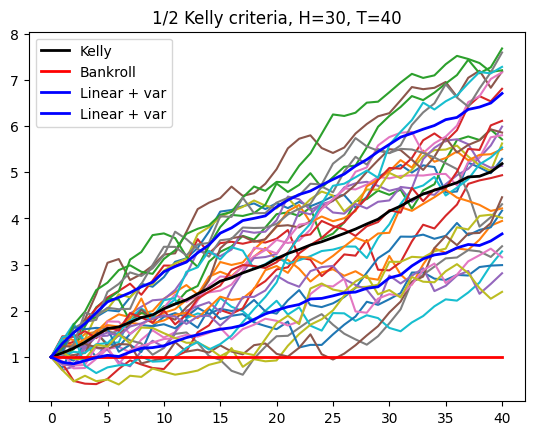

In [190]:
for sim in result_kelly:
    plt.plot(sim)

plt.plot(np.mean(result_kelly, axis=0), label='Kelly', color='black', linewidth=2)
plt.plot(np.ones(T+1), label='Bankroll', color='red', linewidth=2)
plt.plot(np.mean(result_kelly, axis=0) + np.sqrt(np.var(result_kelly, axis=0)), label='Linear + var', color='blue', linewidth=2)
plt.plot(np.mean(result_kelly, axis=0) - np.sqrt(np.var(result_kelly, axis=0)), label='Linear + var', color='blue', linewidth=2)
plt.plot()
plt.legend()
plt.title(f'1/2 Kelly criteria, H={H}, T={T}')
plt.show()


<Axes: ylabel='Count'>

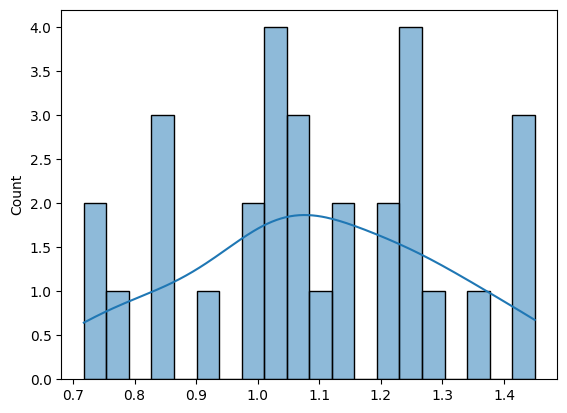

In [209]:
import seaborn as sns
sns.histplot([result_kelly[k][1] for k in range(H)], bins=20, kde=True)

<Axes: ylabel='Count'>

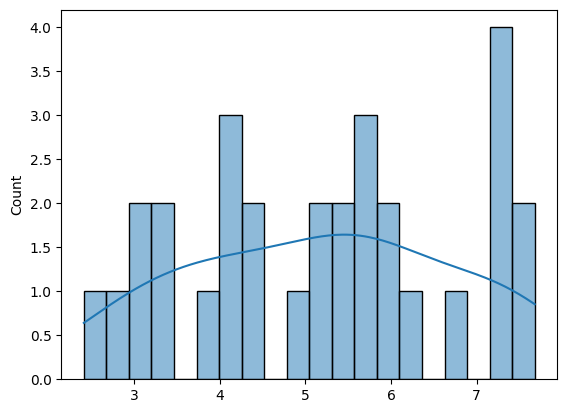

In [203]:
import seaborn as sns
sns.histplot([result_kelly[k][-1] for k in range(H)], bins=20, kde=True)

In [191]:
[result_kelly[k][-1] for k in range(H)]

[5.289372800923383,
 3.9462833613169863,
 5.711402887287294,
 4.935271164386308,
 5.987343764373311,
 7.178485840156292,
 5.801202718867998,
 3.3979163701526414,
 5.6222215700657525,
 3.28713627888462,
 4.16959210153067,
 5.496615422266104,
 7.677639097707732,
 6.805417336912975,
 5.139012564565831,
 5.858210142782816,
 7.160119811234751,
 4.307374832385951,
 4.014082514158091,
 5.536302811094495,
 2.9899787707166414,
 4.21683628723513,
 7.20582412356795,
 6.110968527172587,
 2.8134524255336886,
 4.458727894448023,
 3.158782920305209,
 7.591142351568197,
 2.41117733950737,
 7.279602879452999]

In [164]:
V = np.var([result_kelly[k][-1] for k in range(H)])
E = np.mean([result_kelly[k][-1] for k in range(H)])
print(f'Kelly: E = {E:.3f}, V = {V:.3f}')

Kelly: E = 5.185, V = 2.309


In [166]:
V = np.var([result_kelly[k][1] for k in range(H)])
E = np.mean([result_kelly[k][1] for k in range(H)])
print(f'Kelly: E = {E:.3f}, V = {V:.3f}')

Kelly: E = 1.090, V = 0.041


In [167]:
np.mean(result_kelly, axis=0)

array([1.  , 1.09, 1.19, 1.32, 1.47, 1.62, 1.65, 1.75, 1.86, 1.91, 2.04,
       2.15, 2.24, 2.37, 2.49, 2.64, 2.72, 2.82, 2.91, 2.99, 3.13, 3.24,
       3.33, 3.43, 3.5 , 3.58, 3.68, 3.77, 3.88, 3.98, 4.16, 4.27, 4.41,
       4.53, 4.61, 4.69, 4.77, 4.9 , 4.91, 5.  , 5.19])

In [168]:
np.var(result_kelly, axis=0)

array([0.  , 0.04, 0.11, 0.16, 0.24, 0.33, 0.41, 0.41, 0.44, 0.5 , 0.64,
       0.66, 0.67, 0.79, 0.88, 1.08, 1.17, 1.28, 1.2 , 1.12, 1.25, 1.33,
       1.42, 1.36, 1.5 , 1.59, 1.65, 1.86, 1.94, 2.14, 2.08, 2.22, 2.06,
       1.97, 1.96, 2.09, 1.99, 2.13, 2.24, 2.23, 2.31])

In [171]:
np.mean(result_kelly, axis=0) + np.var(result_kelly, axis=0)

array([1.  , 1.13, 1.31, 1.48, 1.71, 1.95, 2.06, 2.16, 2.3 , 2.41, 2.69,
       2.81, 2.91, 3.16, 3.37, 3.72, 3.88, 4.11, 4.1 , 4.12, 4.38, 4.57,
       4.74, 4.79, 5.  , 5.17, 5.33, 5.63, 5.82, 6.12, 6.24, 6.49, 6.46,
       6.5 , 6.57, 6.78, 6.77, 7.03, 7.16, 7.23, 7.49])

M = 5

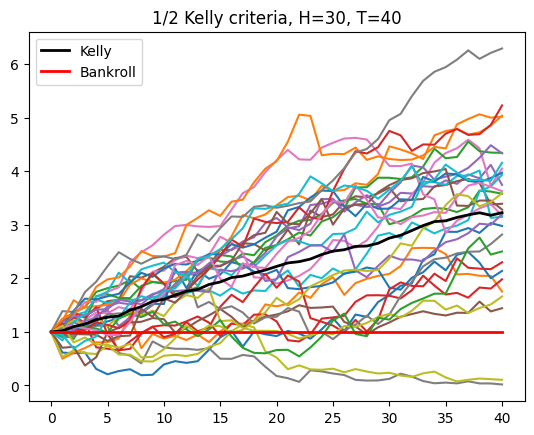

In [125]:
for sim in result_kelly:
    plt.plot(sim)

plt.plot(np.mean(result_kelly, axis=0), label='Kelly', color='black', linewidth=2)
plt.plot(np.ones(T+1), label='Bankroll', color='red', linewidth=2)
plt.legend()
plt.title(f'1/2 Kelly criteria, H={H}, T={T}')
plt.show()


M = 1

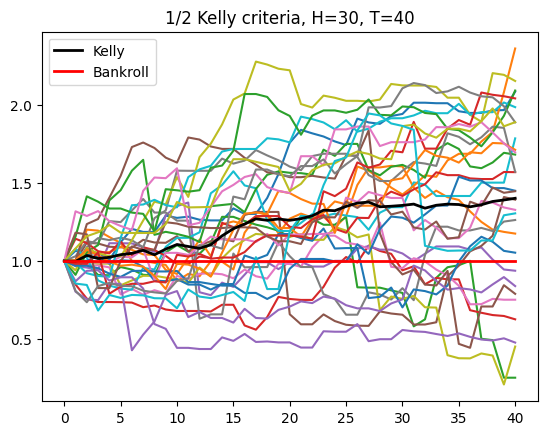

In [131]:
for sim in result_kelly:
    plt.plot(sim)

plt.plot(np.mean(result_kelly, axis=0), label='Kelly', color='black', linewidth=2)
plt.plot(np.ones(T+1), label='Bankroll', color='red', linewidth=2)
plt.legend()
plt.title(f'1/2 Kelly criteria, H={H}, T={T}')
plt.show()


M = 10

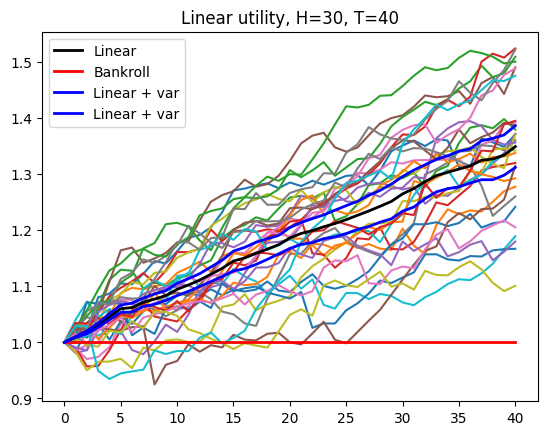

In [212]:
for sim in result_linear:
    plt.plot(sim)

plt.plot(np.mean(result_linear, axis=0), label='Linear', color='black', linewidth=2)
plt.plot(np.ones(T+1), label='Bankroll', color='red', linewidth=2)
plt.plot(np.mean(result_linear, axis=0) + 3 * np.var(result_linear, axis=0), label='Linear + var', color='blue', linewidth=2)
plt.plot(np.mean(result_linear, axis=0) - 3 * np.var(result_linear, axis=0), label='Linear + var', color='blue', linewidth=2)

plt.legend()
plt.title(f'Linear utility, H={H}, T={T}')
plt.show()

<Axes: ylabel='Count'>

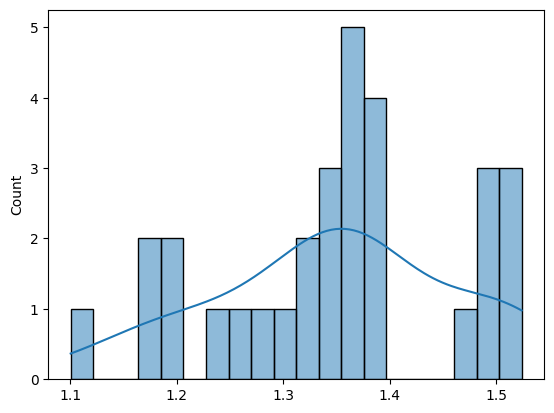

In [211]:
import seaborn as sns
sns.histplot([result_linear[k][-1] for k in range(H)], bins=20, kde=True)



In [181]:
var = np.var([result_linear[k][-1] for k in range(H)])
mean = np.mean([result_linear[k][-1] for k in range(H)])

In [187]:
print(f'Linear: mean = {mean:.3f}, var = {var:.3f}')

Linear: mean = 1.349, var = 0.012


In [183]:
[result_linear[k][-1] for k in range(H)] 

[1.3708317281325595,
 1.2773799029112711,
 1.3791897053818494,
 1.3196511934559716,
 1.3717674743166663,
 1.4899819250020794,
 1.391706068793862,
 1.3604023161229086,
 1.3701248489486284,
 1.1890990806963238,
 1.2414385762247744,
 1.337334937284742,
 1.5087935121052127,
 1.5236236546128483,
 1.3561370441809208,
 1.3864928354050619,
 1.4882760170251395,
 1.2599777496883344,
 1.3415034246651958,
 1.3492042335152263,
 1.1667108585177983,
 1.2923269481398798,
 1.5002019129988522,
 1.3945168661368896,
 1.1796718712218028,
 1.3143774909796169,
 1.2048571616249362,
 1.5219224199745651,
 1.100626381404494,
 1.4750780767378384]

In [188]:
sum([1 if x > mean -  * var and x < mean + 3 * var else 0 for x in [result_linear[k][-1] for k in range(H)]]) / H

0.36666666666666664

In [176]:
np.var(result_linear, axis=0)

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])

In [162]:
np.var([result_linear[k][-1] for k in range(H)])

0.012393956048493329

M = 5

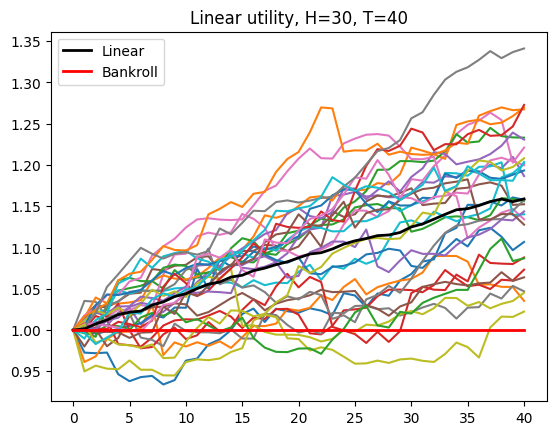

In [126]:
for sim in result_linear:
    plt.plot(sim)

plt.plot(np.mean(result_linear, axis=0), label='Linear', color='black', linewidth=2)
plt.plot(np.ones(T+1), label='Bankroll', color='red', linewidth=2)
plt.legend()
plt.title(f'Linear utility, H={H}, T={T}')
plt.show()

M = 1

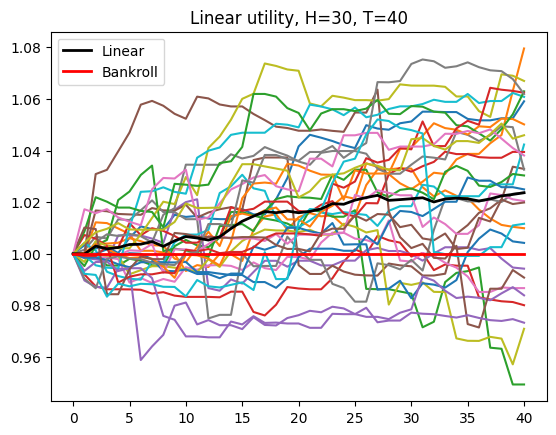

In [132]:
for sim in result_linear:
    plt.plot(sim)

plt.plot(np.mean(result_linear, axis=0), label='Linear', color='black', linewidth=2)
plt.plot(np.ones(T+1), label='Bankroll', color='red', linewidth=2)
plt.legend()
plt.title(f'Linear utility, H={H}, T={T}')
plt.show()

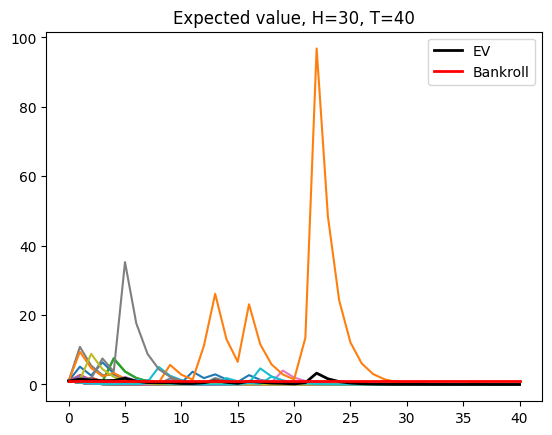

In [127]:
for sim in result_ev:
    plt.plot(sim)

plt.plot(np.mean(result_ev, axis=0), label='EV', color='black', linewidth=2)
plt.plot(np.ones(T+1), label='Bankroll', color='red', linewidth=2)
plt.legend()
plt.title(f'Expected value, H={H}, T={T}')
plt.show()

Text(0.5, 1.0, 'Dumb utility, H=30, T=40')

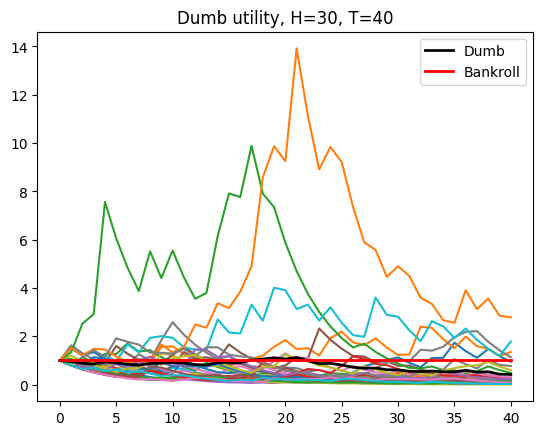

In [128]:
for sim in result_dumb:
    plt.plot(sim)

plt.plot(np.mean(result_dumb, axis=0), label='Dumb', color='black', linewidth=2)
plt.plot(np.ones(T+1), label='Bankroll', color='red', linewidth=2)
plt.legend()
plt.title(f'Dumb utility, H={H}, T={T}')

In [102]:
%%time
for _ in range(10_000):
    simulate_prob(M, N, BIAS_BOOKMAKER, BIAS_PLAYER, STD_BOOKMAKER, STD_PLAYER, MARGIN_BOOKMAKER, MIN_PROB, MAX_PROB)


CPU times: total: 469 ms
Wall time: 476 ms


In [103]:
%%time
for _ in range(10_000):
    x = [np.random.choice(N, p=r[i]) for i in range(M)]

CPU times: total: 672 ms
Wall time: 659 ms


In [106]:
%%time
for _ in range(100):
    f = 1/2 * resolve_fik(o, t, lambda  f, o, t : player_utility_kelly_criteria(f, o, t, B=1))

CPU times: total: 2.48 s
Wall time: 2.56 s


In [97]:
r, o, t = simulate_prob(M, N, BIAS_BOOKMAKER, BIAS_PLAYER, STD_BOOKMAKER, STD_PLAYER, MARGIN_BOOKMAKER, MIN_PROB, MAX_PROB)
f = 1/2 * resolve_fik(o, t, lambda  f, o, t : player_utility_kelly_criteria(f, o, t, B=1))

In [68]:
K = 10_000

In [74]:
%%time
E = 0
for _ in range(K):
    E += player_gain_expected_value(f, o, r)
E /= K
E


CPU times: total: 141 ms
Wall time: 158 ms


0.25687984486351684

In [73]:
%%time
E = 0
for _ in range(K):
    E += player_gain_expected_value_numpy(f, o, r)
E /= K
E

CPU times: total: 125 ms
Wall time: 111 ms


0.25687984486351684

In [86]:
%%time
V = 0
for _ in range(K):
    V += player_gain_variance(f, o, r)
V /= K
V

CPU times: total: 656 ms
Wall time: 661 ms


0.014905168432275644

In [91]:
%%time
V = 0
for _ in range(K):
    V += player_gain_variance_numpy(f, o, r)
V /= K
V

CPU times: total: 828 ms
Wall time: 822 ms


0.014905168432275618

In [9]:
V = player_gain_variance(f, o, r)
V

0.014905168432272799

In [10]:
V = player_gain_variance_numpy(f, o, r)
V

0.014905168432272724

In [33]:
result_kelly

[[1,
  0.9922689069038402,
  0.9652620966895434,
  0.9564592573123967,
  0.9961703228309225,
  1.1553541587195464,
  1.5008277232296372,
  1.6773160614568845,
  1.8187103490756826,
  2.133170907395135,
  2.1834139029117168,
  2.0608554360188016,
  1.691423520967085,
  1.651141201051638,
  1.6109406242218203,
  1.4928628447975476,
  1.5670698553462958,
  1.6110949900915306,
  1.7925516402800912,
  2.022778999748562,
  2.1861797749774277,
  2.1053815539864527,
  2.313276362065813,
  2.325504563875937,
  2.338111973121999,
  2.6451779544626284,
  2.8402624060317097,
  2.572326176028792,
  2.51926293150837,
  2.6654639067673047,
  2.9032023676069763,
  2.8571127573081094,
  3.176048001216973,
  3.0714562105978733,
  2.9794513352309018,
  2.8209165925508444,
  2.837996709402316,
  3.0730878892545546,
  3.1932125603170882,
  3.4088723984850504,
  3.150808488419415,
  3.1671497140982194,
  3.2141479590005124,
  3.1905537937515596,
  3.236302312313136,
  3.517060860819992,
  3.472453088610884,

In [32]:
var_kelly = np.var(result_kelly, axis=0)
var_linear = np.var(result_linear, axis=0)
var_dumb = np.var(result_dumb, axis=0)

print(f'Kelly: {np.mean(var_kelly):.3f}')
print(f'Linear: {np.mean(var_linear):.3f}')
print(f'Dumb: {np.mean(var_dumb):.3f}')


Kelly: 1.656
Linear: 0.200
Dumb: 0.552


In [24]:
print(np.argmax(o, axis=1))
print(o)
f = np.zeros((M, N))
for k in range(M):
    f[k, np.argmax(o[k])] = 1
f = f / np.sum(f)
print(f)

[0 0 0 1 0 2 2 1 1 0 0 2 0 0 0 2 0 0 2 0]
[[ 3.75  2.54  2.36]
 [12.49  1.28  4.51]
 [16.3  10.32  1.06]
 [ 6.7  19.81  1.11]
 [ 3.83  2.46  2.26]
 [ 1.74  2.84  6.65]
 [ 1.65  3.87  4.58]
 [ 2.44  6.18  1.96]
 [ 2.39  5.83  1.82]
 [11.78  1.29  4.31]
 [ 5.21  1.7   3.04]
 [ 2.5   2.05  4.97]
 [ 5.61  1.62  3.34]
 [ 6.03  2.58  1.83]
 [10.82  1.24  4.98]
 [ 1.67  2.18 16.97]
 [22.77  4.78  1.2 ]
 [ 6.02  1.58  2.44]
 [ 1.15  6.83 12.11]
 [18.4   5.31  1.15]]
[[0.05 0.   0.  ]
 [0.05 0.   0.  ]
 [0.05 0.   0.  ]
 [0.   0.05 0.  ]
 [0.05 0.   0.  ]
 [0.   0.   0.05]
 [0.   0.   0.05]
 [0.   0.05 0.  ]
 [0.   0.05 0.  ]
 [0.05 0.   0.  ]
 [0.05 0.   0.  ]
 [0.   0.   0.05]
 [0.05 0.   0.  ]
 [0.05 0.   0.  ]
 [0.05 0.   0.  ]
 [0.   0.   0.05]
 [0.05 0.   0.  ]
 [0.05 0.   0.  ]
 [0.   0.   0.05]
 [0.05 0.   0.  ]]


In [66]:
B

2.9885968373508537e-05

In [23]:
r.shape

(1, 2)

In [28]:
np.random.normal(0, 0.1, r.shape)

array([[-0.18, -0.02]])

In [48]:
0.51*(- 1) + 0.49*(2.34 - 1)

0.14659999999999995

In [5]:
r, o, t = simulate_prob(M, N, STD_BOOKMAKER, STD_PLAYER, MARGIN_BOOKMAKER, MIN_PROB, MAX_PROB)
f = resolve_fik(o, r, player_utility_kelly_criteria)
x = [np.random.choice(N, p=r[i]) for i in range(M)]
g = np.sum([f[k, i] * (o[k, i] - 1) * (x[k] == i) for k in range(M)] for i in range(N))

Répartition optimale de la bankroll:
[[3.64361997e-03 0.00000000e+00 0.00000000e+00]
 [1.09452764e-02 3.44397103e-17 8.82053889e-17]
 [0.00000000e+00 3.27983618e-01 1.29809188e-01]
 [0.00000000e+00 8.45712690e-02 2.14801843e-01]
 [7.85477414e-18 6.18809131e-02 8.84688874e-17]
 [1.26470259e-02 9.59972671e-17 1.37739938e-17]
 [2.38714595e-02 3.48839682e-02 0.00000000e+00]
 [1.09018130e-16 2.55132392e-02 1.80164763e-16]
 [4.72060690e-02 1.26167955e-16 8.36853052e-03]
 [6.04149514e-17 1.38739799e-02 1.28894686e-16]]


C:\Users\jdelavande\AppData\Local\Temp\ipykernel_24516\1049702632.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  g = np.sum([f[k, i] * (o[k, i] - 1) * (x[k] == i) for k in range(M)] for i in range(N))


TypeError: unsupported operand type(s) for +: 'int' and 'list'

In [95]:
f = resolve_fik(o, r, player_utility_kelly_criteria)
print(np.sum(result))
print(f'utility = {-player_utility_kelly_criteria(f, o, r)}')
print(f'expected_value = {player_gain_expected_value(f, o, r)}')
#print(f'variance = {player_gain_variance(result, o, r)}')
print(f'ecart_type = {np.sqrt(player_gain_variance(f, o, r))}')


Répartition optimale de la bankroll:
[[4.73983973e-02 6.22118014e-02 1.03805518e-01]
 [6.63824654e-17 6.38685309e-18 8.22022794e-03]
 [3.51651000e-17 0.00000000e+00 3.71596485e-02]
 [0.00000000e+00 4.33131388e-02 1.64978860e-02]
 [4.14986438e-02 2.52190109e-02 2.93255614e-16]
 [4.79093611e-02 3.06228045e-17 2.28358178e-02]
 [2.48729718e-02 3.68010727e-01 1.22364378e-17]
 [7.89140926e-03 4.17987196e-17 1.64032295e-02]
 [1.48983753e-17 7.46713317e-02 2.17176455e-02]
 [1.46919580e-02 1.29559145e-17 1.56712766e-02]]
1.0000000000000009
utility = 0.19988872725270634
expected_value = 0.32098287782403784
ecart_type = 0.3730392650733456


In [25]:
x = [np.random.choice(N, p=r[i]) for i in range(M)]
x

[0, 2, 0, 1, 2, 1, 1, 0, 1, 1]

In [27]:
for k in range(M):
    match_k = []
    for i in range(N):
        match_k.append((x[k] == i))
    print(f'k = {k} : {match_k}')

k = 0 : [True, False, False]
k = 1 : [False, False, True]
k = 2 : [True, False, False]
k = 3 : [False, True, False]
k = 4 : [False, False, True]
k = 5 : [False, True, False]
k = 6 : [False, True, False]
k = 7 : [True, False, False]
k = 8 : [False, True, False]
k = 9 : [False, True, False]


In [97]:
g = 0
for k in range(M):
    for i in range(N):
        g += f[k, i] * (o[k, i] - 1) * (x[k] == i)

g

0.9174756801979563

In [4]:
np.sum([f[k, i] * (o[k, i] - 1) * (x[k] == i) for k in range(M)] for i in range(N))

C:\Users\jdelavande\AppData\Local\Temp\ipykernel_24516\1317911945.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum([f[k, i] * (o[k, i] - 1) * (x[k] == i) for k in range(M)] for i in range(N))


NameError: name 'f' is not defined